In [64]:
#Create a blank image
blank_image = np.zeros((1080,1920,3), np.uint8) #Size of the image 1080 height, 1920 width, 3 channels of colour
blank_image[:, :] = [255, 255, 255] #Sets the color to white

In [65]:
#Draws circle ; center, radius, colour, -1 to fill the shape
cv2.circle(blank_image, (960, 540), 200, (0, 255, 0), -1)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [66]:
#write text
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(blank_image, 'zone_id', (960, 540), 
            font, 2, (255, 0, 0), 5, cv2.LINE_AA) 
  



array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

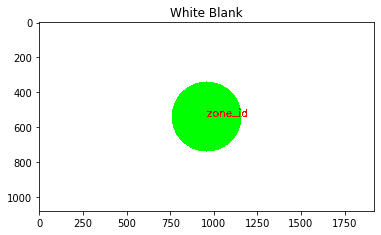

In [67]:
# to show the image inside the Jupyter notebook
plt.imshow(blank_image)
plt.title("White Blank")
plt.show()

In [ ]:
#to show the image outside the notebook
cv2.imshow("White Blank", blank_image) 

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
from pyproj import Proj, transform
import cv2
import mysql.connector

In [78]:
def shp_to_df(sf):
    """
    This function extracts a dataframe from a shapefile. The dataframe obtaines is used 
    to access more efficiently the list of indexes as well as doing the association
    between a zone id and its associated borough to be able to filter on a borough.

    Input: shapefile
    
    Output: associated dataframe of the input shapefile
    """
        
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    return df


def calculate_centroid(points):
    """
    Given a list of tuples of coordinates this function calculates the mean on each axis.
    This is used to obtain the center of a given shape, through the list of points of its
    boundaries.

    Input: list of tuples of coordinates of a shape
    
    Output: the center coordinates of the shape
    """
        
    x_sum = 0
    y_sum = 0
    for coords in points:
        x_sum += coords[0]
        y_sum += coords[1]
        
    x_mean = x_sum/len(points)
    y_mean = y_sum/len(points)
    
    return x_mean, y_mean


def calculate_boundaries(points):
    """
    This function returns the coordinates of the max and min points of the boundaries
    of a shape. 
    It is used for a single shape (i.e. finding the extreme limits of a shape) as well
    as for the entire map. 

    Input: list of tuples of coordinates of a shape, or list of all the max and min
    sets of coordinates of all the shapes of the map. 
    
    Output: the coordinates of the most extreme points of the targeted area (shape or map)
    """
        
    x_max = -99999999
    x_min = 99999999
    y_max = -99999999
    y_min = 99999999
    
    for coords in points:
        if coords[0] > x_max:
            x_max = coords[0]
        if coords[0] < x_min:
            x_min = coords[0]
        if coords[1] > y_max:
            y_max = coords[1]
        if coords[1] < y_min:
            y_min = coords[1]
        
    max_bound = (x_max, y_max)
    min_bound = (x_min, y_min)
    
    return max_bound, min_bound


def process_shape_boundaries(df_sf, sf):
    """
    This function builds a dictionary with the shape boundaries coordinates before conversion,
    for each zone id available in the shape file. 

    Input: shapefile and dataframe converted from the shapefile (the dataframe is used only
    to get the zone_id number).
    
    Output: a dictionary with for each zone id the set of boundary coordinates the initial
    coordinate system.
    """
    
    shape_dict = {}
    index_list = df_sf.index.tolist()
    
    for zone_id in index_list:
        #for each zone id available in the shapefile
        if zone_id not in shape_dict:
            #we only process the coordinates if it is not yet included in the dictionary
            shape_zone = sf.shape(zone_id)
            
            points = [(i[0], i[1]) for i in shape_zone.points]
            
            x_center, y_center = calculate_centroid(points)
            max_bound, min_bound = calculate_boundaries(points)
            
            #we add to the dictionary, for the zone id, the shape boundaries as well
            #as the coordinates of the center of the shape znd the zone extreme boundaries
            shape_dict[zone_id] = {}
            shape_dict[zone_id]['points'] = points
            shape_dict[zone_id]['center'] = (x_center, y_center)
            shape_dict[zone_id]['max_bound'] = max_bound
            shape_dict[zone_id]['min_bound'] = min_bound
            
    return shape_dict  

In [79]:
def find_max_coords(shape_dict):
    """
    This function is used to obtain the set of max and min coordinates of an entire map.
    It uses another function to perform the comparison of the values of the
    coordinates (calculate_boundaries). 

    Input: the shape dictionary, in which for all shape there is the max and min tuples. 
    The function regroups all the max and min into a list to use the calculate_boundaries
    function.
    
    Output: the coordinates of the most extreme points of the map.
    """
    
    all_max_bound = []
    all_min_bound = []
    
    for zone in shape_dict:
        zone_shape = shape_dict[zone]
        max_bound_zone = zone_shape['max_bound']
        min_bound_zone = zone_shape['min_bound']
        all_max_bound.append(max_bound_zone)
        all_min_bound.append(min_bound_zone)
    
    map_max_bound, unused_max = calculate_boundaries(all_max_bound)
    unused_min, map_min_bound = calculate_boundaries(all_min_bound)
    
    return map_max_bound, map_min_bound


def define_projection(map_max_bound, map_min_bound, image_size):
    """
    This function compute the projection parameter using the coordinates of the max and
    min points of the area to draw (that we call the map).
    It returns the conversion factor value as well as the axis to use to center the area in 
    the image after the conversion.
    If with the conversion the y-axis is used to scale the image (i.e. the map 'fits' the
    image on the y_axis), we will have to center the map on the x-axis. 
    
    Note that the image size is hard-coded in this function (high resolution). 
    
    Input: max and min boundaries coordinates tuples of the map to draw
    
    Output: a dictionary with the parameters to perform the projection

    """
    
    #We get the max 'coordinates' for both the target image and the shape we want to draw
    image_x_max = image_size[0]
    image_y_max = image_size[1]
    map_x_max = map_max_bound[0]
    map_y_max = map_max_bound[1]
    map_x_min = map_min_bound[0]
    map_y_min = map_min_bound[1]
    
    projection = {}

    #we check which size is bigger to know based on which axis we want to scale our shape to
    #we do the comparison using the aspect ratio expectations (dividing each axis by the
    #size of the target axis in the new scale)
    if (map_x_max - map_x_min)/image_x_max > (map_y_max - map_y_min)/image_y_max:
        conversion = image_x_max / (map_x_max - map_x_min)
        axis_to_center = 'y'#we store the axis we will want to center on based on which
        #axis we perform the scaling from
    else:
        conversion = image_y_max / (map_y_max - map_y_min)
        axis_to_center = 'x'

    projection['image_size'] = image_size
    projection['map_max_bound'] = map_max_bound
    projection['map_min_bound'] = map_min_bound
    projection['conversion'] = conversion
    projection['axis_to_center'] = axis_to_center
    
    return projection


def convert_projection(x, y, projection, inverse=False):
    """
    This function converts coordinates from one projection system to another.
    As to simplify centering later on, we also translate the coordinates to the origin. In
    the case of an inversed projection, we move back the points to their initial absciss. 
    
    Input: x an y coordinates to convert, as well as the "direction" of 
    the projection (i.e whether we want to project from the original coordinate system
    to the image scale (inverse = False), or the inverse (inverse = True).
    
    Output: the x and y coordinates in the new coordinate system.
    """
    
    x_min = projection['map_min_bound'][0]
    y_min = projection['map_min_bound'][1]
    conversion = projection['conversion']
    
    if inverse == False:
        #to be able to center the image, we first translate the coordinates to the origin
        x = (x - x_min) *conversion
        y = (y - y_min) *conversion
    else:
        x = (x + x_min) /conversion
        y = (y + y_min) /conversion
        
    return x, y


def convert_shape_boundaries(zone_shape_dict, projection):
    """
    This function edits the dictionary with the shape boundaries coordinates by converting
    them to the image scale 'coordinate' system.  

    Input: shape boundaries dictionary in the initial coordinate system
    
    Output: a dictionary with for each zone id the set of boundary coordinates 
    in the image scale, centered.
    """
    
    converted_dict = {}
    axis_to_center = projection['axis_to_center']
    image_x_max = projection['image_size'][0]
    image_y_max = projection['image_size'][1]
    map_max_bound_converted = (convert_projection(projection['map_max_bound'][0], projection['map_max_bound'][1], projection))
    map_min_bound_converted = (convert_projection(projection['map_min_bound'][0], projection['map_min_bound'][1], projection))
    
    if axis_to_center == 'x':
        center_translation = (image_x_max - (map_max_bound_converted[0] - map_min_bound_converted[0]))/2
    else:
        center_translation = (image_y_max - (map_max_bound_converted[1] - map_min_bound_converted[1]))/2
    
    
    for zone_id in zone_shape_dict:
        curr_shape = zone_shape_dict[zone_id]
        
        points = curr_shape['points']
        x_center = curr_shape['center'][0]
        y_center = curr_shape['center'][1]
        max_bound = curr_shape['max_bound']
        min_bound = curr_shape['min_bound']
        
        converted_points = []
        for point in points:
            #we convert the coordinates to the new coordinate system
            converted_point = [0, 0] 
            converted_point[0], converted_point[1] = convert_projection(point[0], point[1], projection)
            #we center the map on the axis that was not used to scale the image
            if axis_to_center == 'x':
                converted_point[0] = converted_point[0] + center_translation
            else:
                converted_point[1] = converted_point[1] + center_translation
            
            #we mirror the image to match the axis alignment
            converted_point[1] = image_y_max - converted_point[1]
            converted_points.append(converted_point)
        
        #we convert the center and the max and min boundaries
        x_center, y_center = calculate_centroid(converted_points)
        max_bound = (convert_projection(max_bound[0], max_bound[1], projection))
        min_bound = (convert_projection(min_bound[0], min_bound[1], projection))
        
        
        #We edit the dictionary with the new coordinates
        converted_dict[zone_id] = {}
        converted_dict[zone_id]['points'] = converted_points
        converted_dict[zone_id]['center'] = (x_center, y_center)
        converted_dict[zone_id]['max_bound'] = max_bound
        converted_dict[zone_id]['min_bound'] = min_bound
        
    return converted_dict  

In [80]:
def get_shape_set_to_draw(map_type, shape_dict, df_sf, image_size):
    """
    This function returns the dictionary of all shapes that will be drawn on the base
    map, depending on the choice of the user to draw either the whole city or just a borough.
    The dictionary is indexed per zone_id (0 to 262, so would need conversion to match the
    index scale of PULocationID and DOLocationID, 1 to 263), with for each zone a dictionary
    with all relevant *converted* coordinates (boundary points, center, max and min boundary
    points). 
    Note: we perform the conversion on the coordinates of the shapes we want to draw only. 
    This is why we first reduce the dictionary of shapes to draw to a borough if needed. 
    
    Input: the targeted base map type, the shape boundaries dictionary in the 
    initial coordinate system, the image_size (to calculate the projection parameters) and
    the dataframe obtained from the shapefile (to select only zones from a specific borough).
    
    Output: a dictionary for only the zones to draw with the boundary coordinates 
    in the image scale, and centered.
    """
    
    #we define if we want to draw the whole map or only a borough (in this case map_type
    #should be the borough name)
    if map_type == 'total':
        shape_dict = shape_dict
    else:
        #we select the list of zone_id we want to draw that belong only to the targeted 
        #borough to draw
        shape_dict = reduce_shape_dict_to_borough(shape_dict, df_sf, map_type)
    
    #We define the projection parameters to be able to convert the coordinates into
    #the image scale coordinate system
    #we convert the coordinates of the shapes to draw
    map_max_bound, map_min_bound = find_max_coords(shape_dict)
    projection = define_projection(map_max_bound, map_min_bound, image_size)
    converted_shape_dict = convert_shape_boundaries(shape_dict, projection)
    
    return converted_shape_dict, projection


def reduce_shape_dict_to_borough(shape_dict, df_sf, borough_name):
    """
    This function returns a reduced dictionary of shapes limited to the borough which name
    is provided as an argument. 
    The dictionary is indexed per zone_id (0 to 262, so would need conversion to match the
    index scale of PULocationID and DOLocationID, 1 to 263), with for each zone a dictionary
    with all relevant coordinates (boundary points, center, max and min boundary
    points) in the original coordinate system (since the dictionary provided as an input is
    not yet converted).
    
    Input: the shape boundaries dictionary in the initial coordinate system, the borough 
    name we want to select zones from and the dataframe obtained from the shapefile 
    (to make the association of zone id and borough name).
    
    Output: a dictionary for only the zones to draw with the of boundary coordinates 
    in the initial coordinate system.
    """
        
    borough_df = df_sf[df_sf['borough']==borough_name]
    borough_id = []
    for objectid in borough_df.index:
        borough_id.append(objectid)
    
    reduced_shape_dict = {}
    #we add to the reduced_shape_dict only the zones belonging to the borough area targeted
    for zone_id in borough_id:
        reduced_shape_dict[zone_id] = shape_dict[zone_id]
    
    return reduced_shape_dict


def draw_base_map(draw_dict):
    """
    This function returns a base map image of the zone we want to render. It is provided
    a dictionary with the parameters of the rendering. Such dictionary should look like the
    example below.
    draw_dict = {'image_size':[1920, 1080], 'map_type':'Manhattan', 
             'title':'Passenger flow on Mondays of Jan 2018 in total', 
             'shape_dict':shape_boundaries, 'df_sf':df_sf}
    
    Input: a dictionary with the attributes of the rendering, such as the image size, 
    the title, the targeted area to draw (total for the whole city, or a single borough
    provided with its name), the shape boundaries dictionary in the initial coordinate 
    system, and the dataframe obtained from the shapefile (to make the association of 
    zone id and borough name).
    
    Output: the image of the base map.
    """
    
    
    #We extract the variables we will need from the input dictionary
    image_size = draw_dict['image_size']
    map_type = draw_dict['map_type']
    title = draw_dict['title']
    shape_dict = draw_dict['shape_dict']
    df_sf = draw_dict['df_sf']
                    
    #first we create a blank image, on which we will draw the base map
    width = image_size[0]
    height = image_size[1]
    base_map = np.zeros((height,width,3), np.uint8) #Size of the image 1080 height, 1920 width, 3 channels of colour
    base_map[:, :] = [255, 255, 255] #Sets the color to white
    
    #we isolate the set of shapes we want to draw in the right coordinate system
    converted_shape_dict, projection = get_shape_set_to_draw(map_type, shape_dict, df_sf, image_size)
    
    #we draw each shape of the dictionary on the blank image, 
    #either the full map or only a borough 
    for item in converted_shape_dict:
        shape = converted_shape_dict[item]
        points = shape['points']
        pts = np.array(points, np.int32)
        cv2.polylines(base_map, [pts], True, (0, 0, 0), 1, cv2.LINE_AA)
        
    #we write the title of the base map we render
    #note that its position is based on an image size of [1920, 1080]
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(base_map, title, (1400,1050), font, 0.5,(0,0,0), 1, cv2.LINE_AA)        

    return base_map, projection



In [81]:
def prepare_sql_query(query_dict):
    """
    This function returns the query to execute on the database, which result will be used
    to be plotted on the base map as to build visualizations. 
    It is provided a dictionary with the parameters of the query. 
    Such dictionary should look like the example below.
    
    query_dict = {'data_table':'taxi_rides_2018', 'lookup_table':'taxi_zone_lookup_table', 
                  'aggregated_result':'avg', 'date':single_date, 
                  'specific_weekdays':'on_specific_weekdays', 'filter_on_borough':'Manhattan'}
    
    Input: a dictionary with the attributes of the query, such as
    - the data table (year table) and the lookup table (that will match the zone id with 
    the borough name if we want to filter the query on a single borough)
    - the type of aggregated result we want (count or avg)
    - the time granularity: for a single date (multiple queries should be made for each 
    date if the rendering is wanted for a time period)
    - whether we want to filter the query on a single borough
    
    Note that the specific_weekdays argument is used by another function to filter the 
    single_date to pass.
    
    Output: the query to execute formatted.
    """
        
    
    #We extract the variables we will need from the input dictionary
    data_table = query_dict['data_table']
    lookup_table = query_dict['lookup_table']
    aggregated_result = query_dict['aggregated_result']
    date = query_dict['date']
    filter_on_borough = query_dict['filter_on_borough']
    
    #first we synthesise what we want to fetch
    if aggregated_result == 'count':
        aggregated_result = 'COUNT(passenger_count)'
    elif aggregated_result == 'avg':
        aggregated_result = 'AVG(passenger_count)'
    
    #then we work on the 'WHERE' statements and the JOIN 
    if filter_on_borough != False:
        query = ("SELECT pu_id, do_id, aggregated_result FROM (\
                    SELECT PULocationID pu_id, DOLocationID do_id, {0} aggregated_result\
                    FROM {1} tr_2018\
                    WHERE pickup_date = '{2}'\
                    GROUP BY pu_id, do_id\
                    ORDER by aggregated_result\
                ) AS tr_2018\
                 JOIN {3} lookup_pu\
                 ON lookup_pu.LocationID = tr_2018.pu_id \
                 JOIN {3} lookup_do \
                 ON lookup_do.LocationID = tr_2018.do_id \
                 WHERE lookup_pu.borough_name = '{4}' AND lookup_do.borough_name = '{4}'".format
                (aggregated_result, data_table, date, lookup_table, filter_on_borough))

    else:
        query = ("SELECT PULocationID pu_id, DOLocationID do_id, {0} aggregated_result\
                    FROM {1} AS tr_2018\
                    WHERE pickup_date = '{2}'\
                    GROUP BY pu_id, do_id".format(aggregated_result, data_table, date))


    return query



In [82]:
def make_sql_query(query, database):
    """
    This function connects to the database and execute the query. It returns the result
    as an array of tuples. 

    Input: the formatted query and the database to execute the query on.
    
    Output: the query results.
    """

    
    #connect to the database
    db = mysql.connector.connect(
        host="localhost",
        user="root",
        passwd="dllpsax00",
        database=database
        )

    #execute the query...
    cursor = db.cursor()
    cursor.execute(query)

    # ...and store the output
    results=[]
    for result in cursor:
        results.append(result)

    cursor.close()

    return results

In [83]:
def interpolate_next_position(origin_coords, destination_coords, tot_frames, curr_frame):
    """
    This function calculates the position of a point to render on a map based on
    the distance to cross (between origin and destination), in the total number of frames
    we want (for example 60), and based on the current frame we are rendering.
    The idea is to go from origin to destination in tot_frames, moving a little bit
    between each frame. 

    Input: the coordinates of the origin and destination, to know the distance to cross,
    the total number of frames we have to cross this distance, and the current frame we
    render to know where the point should be. 
    
    Output: the coordinates of the point to render at the given frame. 
    """
        
    #as to perform the arithmetic operations, we convert everything to float for more 
    #precision
    x_origin = float(origin_coords[0])
    y_origin = float(origin_coords[1])
    x_destination = float(destination_coords[0])
    y_destination = float(destination_coords[1])
    tot_frames = float(tot_frames - 1)
    curr_frame = float(curr_frame)
    
    delta_x = (x_destination - x_origin)/tot_frames
    delta_y = (y_destination - y_origin)/tot_frames
    
    #the rendering with OpenCV demands integers values for the positioning, so we convert
    #w and y to int
    new_x = int(x_origin+delta_x*curr_frame)
    new_y = int(y_origin+delta_y*curr_frame)
    
    return new_x, new_y



def render_point_on_map(x_point, y_point, weight, base_map):
    """
    This function simply renders a circle at the x and y coordinates provided, on the
    base map provided, and with a diameter matching the weight given. 
    The weight being for example the count of passengers that went from one zone to another.
    If the origin and the destination are the same, the point is rendered in a different
    color. 

    Input: the index and the direction of the conversion we want to perform
    
    Output: the index converted.
    """
        
    cv2.circle(base_map, (x_point,y_point), weight, (255, 0, 0), -1)
    
    #### Add the color argument
    
    
def convert_id_shape(idx, inverse = False):
    """
    This function converts the id index either from the database query result to the 
    shape_dict index (inverse = False, we want to substract 1), or the inverse (inverse = True).
    This function is useful due to the fact that in the database we use the zone id (index
    from 1 to 263), and with the shape_dict (from the shapefile) we use the row indexes 
    (from 0 to 262).

    Input: the index and the direction of the conversion we want to perform
    
    Output: the index converted.
    """
        
    if inverse == False:
        idx = idx - 1
    else:
        idx = idx + 1
    
    return idx


def render_frame(base_map, query_results, converted_shape_dict):
    """
    This function renders a single frame on a copy of the base map using the query results,
    the shape dictionary converted to the proper coordinate system and another function
    dedicated to rendering the point on the image. 

    Input: the base map to use as a reference, the query results and the shape coordinates
    dictionary to get the coordinates of the centers of the shape (to render the points). 
    
    Output: the image of the frame with the points rendered based on the query results.
    """
        
    for frame in range(0, 60):
        #60 is the number of frames we want with the same query result
        #we make a copy of the map on which we will render the frame (each frame being
        #rendered on a new copy)
        map_rendered = base_map.copy()
        #we get each tuple from the query result, in the form (origin_id, dest_id, weight)
        for itinerary in query_results:
            zone_id_origin = convert_id_shape(itinerary[0])
            zone_id_destination = convert_id_shape(itinerary[1])
            weight = int(itinerary[2]/819*10)
            
            #we get the coordinates of the center of the origin and the destination
            origin_coords = converted_shape_dict[zone_id_origin]['center']
            destination_coords = converted_shape_dict[zone_id_destination]['center']

            if frame == 0:
                #we start the rendering with the point at the origin
                #we convert to int as to be able to plot the point with opencv
                coords_point_to_draw = (int(origin_coords[0]), int(origin_coords[1]))

            else:
                #we extrapolate the position of the point between the origin and the
                #destination, as to have the point move from origin to destination
                #in 60 frames
                coords_point_to_draw = interpolate_next_position(origin_coords, 
                                                                 destination_coords, 60, frame)

            x_point = coords_point_to_draw[0]
            y_point = coords_point_to_draw[1]

            render_point_on_map(x_point, y_point, weight, map_rendered)

        #we save the file
        cv2.imwrite('test_{}.png'.format(frame), map_rendered)
    

def build_query_dict(render_frame_dict):
    """
    This function builds the query dictionary that will be used to query the database.
    Provided several arguments regarding the type of query we want to make, it generates
    a new dictionary that can simply be injected as an argument to the prepare_sql_query
    function. 
    
    The input of this function could look like the example below
    
    render_frame_dict = {'time_granularity':'period', 'period':['2018-01-01','2018-01-01'] ,  
                 'weekdays':[0, 1, 2, 3, 4],'filter_on_borough':'Manhattan', 
                 'base_map':test_map,'map_type':'Manhattan', 'image_size':[1920, 1080],
                 'shape_dict':shape_boundaries, 'df_sf':df_sf, 
                 'database':'nyc_taxi_rides', 'data_table':'taxi_rides_2018', 
                 'lookup_table':'taxi_zone_lookup_table', 'aggregated_result':'avg'}
    
    Note that:
    - time_granularity can have three different values : 'period', 'specific_weekdays'.
    - if time_granularity is set to specific_weekdays, then 'weekdays' must have an array 
    with the indexes of the days to query (0 = Monday, 1= Tuesday, ...).
    - if time_granularity is set to period, then 'period' must have an array with start and
    end date. If only a single date is to be queried, the period type should be used, 
    inputting the same date as start date and end date (ex: ['2018-01-01','2018-01-01']).
    - the filter_on_borough argument is used to filter the query on a specific
    borough (independent from the map_type rendering constraint that will render only a 
    single borough). It can be provided as False (i.e we don't want to filter the query on
    a single borough), or with the name of the borough to filter the results on.
    
    Input: the dictionary providing all the details of the rendering we want to make,
    including what data we want (i.e arguments to pass in the database query) and the
    rendering specifications (unused in this function). 
    
    Output: the dictionary to pass as an argument to the function that generated the
    formatted query input.
    """
    
    #First, we extract the variables we will need from the input dictionary
    time_granularity = render_frame_dict['time_granularity']
    data_table = render_frame_dict['data_table']
    lookup_table = render_frame_dict['lookup_table']
    aggregated_result = render_frame_dict['aggregated_result']
    filter_on_borough = render_frame_dict['filter_on_borough']
    
    #we instantiate the query_dict and start filling it with query parameters
    query_dict = {}
    query_dict['data_table'] = data_table
    query_dict['lookup_table'] = lookup_table
    query_dict['aggregated_result'] = aggregated_result
    
    #we handle the borough related WHEN statement
    if filter_on_borough == False:
        query_dict['filter_on_borough'] = False
    else:
        query_dict['filter_on_borough'] = filter_on_borough
    
    #we handle the time related WHEN statements
    period = render_frame_dict['period']
    start_date = period[0]
    end_date = period[1]
        
    if start_date == end_date:
        query_dict['date'] = start_date

    else:
        #if the period is more than one date, we will have to loop through the
        #date range and render multiple series of 60 frames (1 second at 60 fps per day)
        #Thus the loop needs to be handled by the main plotting function, and here we
        #simply add a flag to the query dict that will be transformed by the plotting
        #function
        query_dict['date'] = 'loop_through_period'

    if time_granularity == 'specific_weekdays':
        specific_weekdays = render_frame_dict['weekdays']
        query_dict['specific_weekdays'] = 'on_specific_weekdays'
    
    else:
        query_dict['specific_weekdays'] = False
    
    
    return query_dict
    


In [84]:
def plot_animation_query_output(render_frame_dict):
    
    
    #note that we have two arguments related to the borough
    #map_type, to know what base map we want to draw (either full map or only a borough)
    #and filter_on_borough, dedicated to the query (we may want to query for the whole city
    #but plot only on a borough and see points cominng from or going outside the borough
    #boundaries, or we may want to reduce our query results to the borough we are plotting)
    
    
    
    #We extract the variables we will need from the input dictionary
    base_map = render_frame_dict['base_map']
    map_type = render_frame_dict['map_type']
    shape_dict = render_frame_dict['shape_dict']
    df_sf = render_frame_dict['df_sf']
    database = render_frame_dict['database']
    image_size = render_frame_dict['image_size']    

    query_dict = build_query_dict(render_frame_dict)


    if query_dict['filter_on_borough'] == False:
        #in this case, we may want the base map to be reduced to map_type, but the query
        #to be performed on the whole city - thus we want to represent points that may
        #not be inside the shape of the reduced base map
        projection = render_frame_dict['projection']
        converted_shape_dict = convert_shape_boundaries(shape_dict, projection)
    
    else:
        #we isolate the set of zones we want to draw points for in the right coordinate system
        converted_shape_dict = get_shape_set_to_draw(map_type, shape_dict, df_sf, image_size)


    if query_dict['date'] == 'loop_through_period':
        #if we have the flag loop_through_period in the query dict, it means the period
        #set for the query is multiple dates, therefore we need to render multiple times
        #60 frames
        period = render_frame_dict['period']
        daterange = pd.date_range(period[0],period[1])
    
        #we run queries for each date in the daterange specified
        for single_date in daterange:   
            if query_dict['specific_weekdays'] == 'on_specific_weekdays':
                weekdays = render_frame_dict['weekdays']
                
                #we check if the date of the daterange matches the weekday(s) we target
                date = pd.Timestamp(single_date)
                
                if date.dayofweek in weekdays:
                    query = prepare_sql_query(query_dict)
                    query_results = make_sql_query(query, database)

                    #we use the results of the query to render 60 frames for this date
                    #we want to render an animation of 1 second per day, at 60 fps. 
                    render_frame(base_map, query_results, converted_shape_dict)
                
                else:
                    #if a date in the range is not among the weekdays we want, we skip it
                    continue
    
    else:
        #we have a single period (i.e. one single day) to render results for and we 
        #just render 60 frames for this period
        #just in case we check that there is no mismatch between the single day and the
        #argument containing specific weekdays restrictions if any
        
        if query_dict['specific_weekdays'] == 'on_specific_weekdays':
                weekdays = render_frame_dict['weekdays']
                
                #we check if the date of the daterange matches the weekday(s) we target
                date = pd.Timestamp(query_dict['date'])
                
                if date.dayofweek in weekdays:
                    query = prepare_sql_query(query_dict)
                    query_results = make_sql_query(query, database)

                    #we use the results of the query to render 60 frames for this date
                    #we want to render an animation of 1 second per day, at 60 fps. 
                    render_frame(base_map, query_results, converted_shape_dict)
        
                else:
                    print("The date selected does not match the weekday(s) indicated. "
                        "Please select either an interval ('time_granularity':'period') "
                        "or a valid weekday(s) list.")
        
        else:
            query = prepare_sql_query(query_dict)
            query_results = make_sql_query(query, database)

            #we use the results of the query to render 60 frames for this date
            #we want to render an animation of 1 second per day, at 60 fps. 
            render_frame(base_map, query_results, converted_shape_dict)
    

In [14]:
shp_path = "/Users/acoullandreau/Desktop/Taxi_rides_DS/taxi_zones/taxi_zones.shp"
sf_nyc = shp.Reader(shp_path)

In [15]:
df_sf = shp_to_df(sf_nyc)

In [16]:
shape_boundaries = process_shape_boundaries(df_sf, sf_nyc)

In [17]:
shape_boundaries

{0: {'points': [(933100.9183527103, 192536.08569720192),
   (933091.0114800561, 192572.17526147654),
   (933088.5848363293, 192604.9701013019),
   (933121.5604029286, 192857.3815947791),
   (933149.268070866, 192978.64529974),
   (933222.303599316, 193293.27321561542),
   (933252.5816221443, 193450.60036714407),
   (933297.7228000937, 193555.43279791903),
   (933330.5712151835, 193748.8233831425),
   (933350.6320882778, 193794.68697530977),
   (933355.7056937596, 193834.0240346551),
   (933365.7979032588, 193886.46647872418),
   (933431.7392324115, 194391.29051182547),
   (933465.0379729305, 194801.09275264665),
   (933463.4338186719, 195227.36293221635),
   (933471.1052103372, 195315.8792411817),
   (933483.7536692393, 195397.82719968376),
   (933511.4361339996, 195509.2545406304),
   (933554.0907006934, 195620.65066105462),
   (933609.1944352826, 195718.9049942211),
   (933669.2474974946, 195797.47528837126),
   (933731.7750771455, 195866.2036557206),
   (933779.2756322531, 195908.73

In [34]:
render_frame_dict = {'time_granularity':'specific_weekdays', 'period':['2018-01-01','2018-01-01'] ,  
                 'weekdays':[1],'filter_on_borough':'Manhattan', 
                 'base_map':test_map,'map_to_render':['Manhattan', 'Bronx'], 'image_size':[1920, 1080],
                 'shape_dict':shape_boundaries, 'df_sf':df_sf, 
                 'database':'nyc_taxi_rides', 'data_table':'taxi_rides_2018', 
                 'lookup_table':'taxi_zone_lookup_table', 'aggregated_result':'count'}



In [42]:
plot_animation_query_output(render_frame_dict)

The date selected does not match the weekday(s) indicated. Please select either an interval ('time_granularity':'period') or a valid weekday(s) list.


In [19]:
test_map

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [18]:
draw_dict = {'image_size':[1920, 1080], 'map_type':'Manhattan', 
             'title':'Passenger flow on Mondays of Jan 2018 in total', 
             'shape_dict':shape_boundaries, 'df_sf':df_sf}

test_map = draw_base_map(draw_dict)

In [283]:
cv2.imshow(draw_dict['title'], test_map)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
center_x = int(shape['center'][0])
center_y = int(shape['center'][1])
cv2.circle(base_map, (center_x,center_y), 5, (255, 255, 0), -1)

In [43]:
draw_dict = {'image_size':[1920, 1080], 'map_type':'total', 
             'title':'Passenger flow on Mondays of Jan 2018 in total', 
             'shape_dict':shape_boundaries, 'df_sf':df_sf}

test_map = draw_base_map(draw_dict)

#cv2.imwrite('test.png', test_map)
cv2.imshow(draw_dict['title'], test_map)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [189]:
query_dict = {'data_table':'taxi_rides_2018', 'lookup_table':'taxi_zone_lookup_table', 
              'aggregated_result':'count', 'per_date':True, 'date':'2018-01-01', 
              'weekdays_only':False, 'weekends_only':False, 'filter_on_borough':'Manhattan'}


test_query = prepare_sql_query(query_dict)
results = make_sql_query(test_query, 'nyc_taxi_rides')



In [ ]:
def reduce_df_to_borough_boundaries(df, df_sf, borough_name):
    """
    This function truncates the dataframe of interest to be limited to a single borough.
    This is useful to compute only the data related to the borough we want to visualize
    the map of. 
    
    Input: dataset, shapefile dataframe and borough name to filter on
    Note that the dataset is expected to be structured as followed:
    - multi-indexed : PULocationID, DOLocationID
    - any feature(s) of interest for the analysis
    
    Output: the dataset of interest reduced to the row with taxi trips that are 
    entirely included in the borough targeted (i.e. PU and DO zones are inside this borough).
    """
    
    #we define two conditions to select a row if the zone_id of both the PU and the DO zones
    #belongs to the targeted borough (defined by its name)
    cond_idx_1 = df.index.get_level_values('DOLocationID').isin(df_sf[df_sf['borough']==borough_name]['OBJECTID'].tolist())
    cond_idx_2 = df.index.get_level_values('PULocationID').isin(df_sf[df_sf['borough']==borough_name]['OBJECTID'].tolist())

    #we define the list of indexes of the dataset that we want to keep
    reduced_idx_list = [df.index[i] for i in range(df.shape[0]) if (cond_idx_1[i] == True) & (cond_idx_2[i] == True)]
    
    #we extract a df from the initial dataset and the condition of the list
    reduced_df = df[df.index.isin(reduced_idx_list)]
    
    return reduced_df



def compute_links(df, weight, shape_dict):
    """
    This function creates a list with the origin zone id, destination zone id and weight
    of each link of the dataset of interest. 
    In order to represent the weight using a transparency parameter, a MinMax normalisation
    is performed on the data (stored in a new column). The normalised value is used
    as the weight for a given link.
    
    Input: the dataset of interest, the name of the column holding the feature we want
    to use as a weight for the line to plot and the shape boundaries dictionary.
    
    Output: a list for each link with origin id, destination id and link weight.
    """
        
    
    links = []
    i=0
    
    #We normalise the data in df
    scaler = MinMaxScaler() 
    df_scaled = scaler.fit_transform(df) 
    df['scaled_weight'] = df_scaled
    
    #we loop though the indexes (multi-index df) of the dataframe, and for each couple
    #we store in a new list the two indexes and the 'weight' of the link (being the value
    #of the weight column targeted)
    for link_centers in df.index:
        link_weight = df.iloc[i]['scaled_weight']
        link = list(link_centers)
        link.append(link_weight)
        links.append(link)
        i+=1
    
    return links


def plot_lines_with_weight(links_to_plot, shape_dict, color_idx):
    """
    This function plots the lines of each link, connecting the center of each zone
    and the color provided by the user for the plot.
    The weight for each link is used to determine with which transparency the line should
    be represented (the less weight the more transparent).
    
    Input: the list of links to plot (obtained using another function), the dictionary 
    with the shape boundaries, the color index to use from the colormap. 
    
    Output: the links plotted on the plot.
    """
        
    #Using the index of the color provided as an input to the function, we define the
    #color from the colormap - we chose viridis as a colormap
    color_idx = plt.cm.viridis(color_idx)
    
    #we loop through the list of links to plot (as a reminder, this list is a list of arrays
    #containing the origine zone_id, the destination zone_id and the link weight)
    for link in links_to_plot:
        origin_id = convert_id_shapefile(link[0])
        #we extract the coordinates of the center using the zone id and the shape boundaries
        #dictionary
        origin_center = [shape_dict[origin_id][2], shape_dict[origin_id][3]]
        destination_id = convert_id_shapefile(link[1])
        destination_center = [shape_dict[destination_id][2], shape_dict[destination_id][3]]

        #we plot the line between the two centers using the weight as transparency
        #and the color chosen by the user
        plt.plot([origin_center[0], destination_center[0]], 
                 [origin_center[1], destination_center[1]], 
                 color=color_idx, alpha=link[2])

        
def plot_points_with_weight(links_to_plot, shape_dict, plot_type, color_idx):
    """
    This function plots the lines of each link, connecting the center of each zone
    and the color provided by the user for the plot.
    The weight for each link is used to determine with which transparency the line should
    be represented (the less weight the more transparent).
    
    Input: the list of links to plot (obtained using another function), the dictionary 
    with the shape boundaries, the color index to use from the colormap. 
    
    Output: the links plotted on the plot.
    """
        
    #Using the index of the color provided as an input to the function, we define the
    #color from the colormap - we chose viridis as a colormap
    color_idx = plt.cm.viridis(color_idx)
    
    #we loop through the list of links to plot (as a reminder, this list is a list of arrays
    #containing the origine zone_id, the destination zone_id and the link weight)
    for link in links_to_plot:
        origin_id = convert_id_shapefile(link[0])
        #we extract the coordinates of the center using the zone id and the shape boundaries
        #dictionary
        origin_center = [shape_dict[origin_id][2], shape_dict[origin_id][3]]
        destination_id = convert_id_shapefile(link[1])
        destination_center = [shape_dict[destination_id][2], shape_dict[destination_id][3]]

        if plot_type =='origin':
            #we plot markers at the center of the origin zones, with a size scale
            #and the color chosen by the user
            plt.plot(origin_center[0], origin_center[1], color=color_idx, marker='o', markersize=100*link[2])
        elif plot_type =='destination':
            #we plot markers at the center of the origin zones, with a size scale
            #and the color chosen by the user
            plt.plot(destination_center[0], destination_center[1], color=color_idx, marker='o', markersize=100*link[2])
               
            

def plot_results(map_dict):
    """
    This function:
    - plots a basemap depending on the input chosen (full NYC map or just a borough)
    - computes the links that have to be plotted (origin-destination centers and 
    link weight)
    - plot either the lines of the links, or the origin or the destination passenger 
    concentration based on the choice of the user
    
    Input: a dictionary with all the required information to execute the set of cleaning
    functions.
    The dictionary is structured as followed (example):
    {'sf':sf_nyc, 'df':df_Mon_jan_2018, 'df_sf':df_sf_nyc,
    'shape_dict':shape_boundaries, 'figsize':(100,100), 'plot_color':0.2,
    'weight':'passenger_count', 'title':'Passenger flow on Mondays of Jan 2018 in Manhattan', 
    'map_type':'Manhattan', 'plot_type':'origin'}
        
    Output: a plot representing the links with their respective weight for a given dataset
    of interest. 
    """
        
    #we extract from the dictionary passed as an input the variable we will use
    map_type = map_dict['map_type']
    sf = map_dict['sf']
    figsize = map_dict['figsize']
    title = map_dict['title']
    shape_dict = map_dict['shape_dict']
    df_sf = map_dict['df_sf']
    df = map_dict['df']
    weight = map_dict['weight']
    plot_type = map_dict['plot_type']
    color_idx_line = map_dict['plot_color'][0]
    color_idx_origin = map_dict['plot_color'][1]
    color_idx_destination = map_dict['plot_color'][2]
    
    #We plot the base map, either the full map or only a borough
    if map_type == 'total':
        fig, ax = plot_nyc_base_map(sf, shape_dict, figsize, title)
    else:
        borough_df = df_sf[df_sf['borough']==map_type]
        fig, ax = plot_borough_base_map(borough_df, shape_dict, figsize, title)
    
    #We calculate the links we want to plot
    if map_type == 'total':
        links_to_plot = compute_links(df, weight, shape_dict)
    else:
        #if the plot wanted is just of a borough, we reduce the df to the links that
        #are completely inside the borough (origin and destination zones are in the borough)
        reduced_df = reduce_df_to_borough_boundaries(df, df_sf, map_type)
        links_to_plot = compute_links(reduced_df, weight, shape_dict)
    
    if plot_type =='origin':
        #We plot the origins
        plot_points_with_weight(links_to_plot, shape_dict, plot_type, color_idx_origin)
    elif plot_type =='destination':
        plot_points_with_weight(links_to_plot, shape_dict, plot_type, color_idx_destination)
    
    #We plot the lines in any case
    plot_lines_with_weight(links_to_plot, shape_dict, color_idx_line)    

In [ ]:
map_dict = {'sf':sf_nyc, 'df':df_week_jan_2018, 'df_sf':df_sf_nyc,
            'shape_dict':shape_boundaries, 'figsize':(80,100), 'plot_color':[0.2, 0.5, 0.8],
    'weight':'passenger_count', 'title':'Passenger flow on Mondays of Jan 2018 in Manhattan', 
    'map_type':'Manhattan', 'plot_type':''}

In [88]:
shp_path = "/Users/acoullandreau/Desktop/Taxi_rides_DS/taxi_zones/taxi_zones.shp"

animation_dict = {'shp_path':shp_path, 'image_size':(1920,1080), 
                  'map_to_render':['Manhattan'],'filter_on_borough':False,
                  'title':'', 
                  'db':'nyc_taxi_rides', 'data_table':'taxi_rides_2018',
                 'lookup_table':'taxi_zone_lookup_table', 'aggregated_result':'count',
                 'time_granularity':'period', 'period':['2018-01-01','2018-01-01'],  
                 'weekdays':[]}

**Python script**

In [89]:
def make_flow_animation(animation_dict):
    #we extract the variables from the input dictionary
    shp_path = animation_dict['shp_path']
    image_size = animation_dict['image_size']
    map_to_render = animation_dict['map_to_render']
    title = animation_dict['title']
    database = animation_dict['db']
    data_table = animation_dict['data_table']
    lookup_table = animation_dict['lookup_table']
    aggregated_result = animation_dict['aggregated_result']
    filter_on_borough = animation_dict['filter_on_borough']
    time_granularity = animation_dict['time_granularity']
    period = animation_dict['period']
    weekdays = animation_dict['weekdays']
    
    #First import the shapefile and build the boundaries dictionary
    shp_path = shp_path
    sf_nyc = shp.Reader(shp_path)
    df_sf = shp_to_df(sf_nyc)
    shape_boundaries = process_shape_boundaries(df_sf, sf_nyc)
    
    #if filter on borough is not False, then it contains the name of a borouhgh, 
    #that happens to be the only one we want to use to draw the base map
    #so we ignore the input of the user in the map_to_render argument
    if filter_on_borough !=False:
        map_to_render = filter_on_borough
    
    
    #Draw the base map and keep it in a saved variable
    if len(map_to_render) == 1:
        map_type = map_to_render[0]
        #we want to render on a single map
        draw_dict = {'image_size':image_size, 'map_type':map_type, 'title':title, 
                 'shape_dict':shape_boundaries, 'df_sf':df_sf}
        base_map, projection = draw_base_map(draw_dict)
        
        #we generate the render frame dictionary
        render_frame_dict = {'time_granularity':time_granularity, 'period':period,  
                 'weekdays':weekdays,'filter_on_borough':filter_on_borough, 
                 'base_map':base_map,'projection':projection, 'map_type':map_type,
                'image_size':image_size,'shape_dict':shape_boundaries, 'df_sf':df_sf, 
                 'database':database, 'data_table':data_table, 
                 'lookup_table':lookup_table, 'aggregated_result':aggregated_result}
        
        #we render the animation!
        plot_animation_query_output(render_frame_dict)
    
    
    else:
        #we want to render multiple animations at once, for different base maps
        for single_map in map_to_render:
            map_type = single_map
            draw_dict = {'image_size':image_size, 'map_type':map_type, 'title':'Titre %s'.format(single_map), 
                 'shape_dict':shape_boundaries, 'df_sf':df_sf}
            base_map, projection = draw_base_map(draw_dict)
            
            #we generate the render frame dictionary
            render_frame_dict = {'time_granularity':time_granularity, 'period':period,  
                     'weekdays':weekdays,'filter_on_borough':filter_on_borough, 
                     'base_map':base_map,'projection':projection, 'map_type':map_type, 
                    'image_size':image_size,'shape_dict':shape_boundaries, 'df_sf':df_sf, 
                     'database':database, 'data_table':data_table, 
                     'lookup_table':lookup_table, 'aggregated_result':aggregated_result}
            #we render the animation!
            plot_animation_query_output(render_frame_dict)
    

In [90]:
make_flow_animation(animation_dict)